In [4]:
import numpy as np
import enum 
from copy import deepcopy
import matplotlib.pyplot as plt

In [11]:
# This class defines direction of payment and type of instrument
class Derivative():
    class OptionType(enum.Enum):
        RECEIVER = 1
        PAYER = -1

def SingleCurve(CP, notional, K, t, Ti, Tm, n, P0T):
    # CP - payer of receiver
    # K - strike
    # t - today's date in number of years passed since inception of swap
    # Ti - beginning of the swap
    # Tm - end of Swap
    # n - number of payment dates between Ti and Tm
    if t <= Ti:
        ti_grid = np.linspace(Ti, Tm, int(n))
        tau = ti_grid[1] - ti_grid[0]
        
        temp = 0.0
            
        for (idx, ti) in enumerate(ti_grid):
            if idx > 0:
                temp = temp + tau * P0T(ti)

        P_t_Ti = P0T(Ti)
        P_t_Tm = P0T(Tm)
        
        if CP == Derivative.OptionType.PAYER:
            swap = (P_t_Ti - P_t_Tm) - K * temp
        elif CP == Derivative.OptionType.RECEIVER:
            swap = K * temp - (P_t_Ti - P_t_Tm)

    return swap * notional

def MultiCurve(CP, notional, K, t, Ti, Tm, n, P0T, P0TFrd):
    # CP - payer of receiver
    # K - strike
    # t - today's date
    # Ti - beginning of the swap
    # Tm - end of Swap
    # n - number of dates payments between Ti and Tm
    ti_grid = np.linspace(Ti, Tm, int(n))
    tau = ti_grid[1] - ti_grid[0]
    swap = 0.0

    # Pricing a spot starting swap
    if t <= Ti:
        for (idx,ti) in enumerate(ti_grid):
            if idx > 0:
                # L(t_0,t_{k-1},t_{k}) from the forward curve
                L_frwd = 1.0 / tau * (P0TFrd(ti_grid[idx - 1]) - P0TFrd(ti_grid[idx])) / P0TFrd(ti_grid[idx])
                if CP == Derivative.OptionType.PAYER:
                    swap += tau * P0T(ti_grid[idx]) * (L_frwd - K)
                elif CP == Derivative.OptionType.RECEIVER:
                    swap += tau * P0T(ti_grid[idx]) * (K - L_frwd)
    # Pricing a seasoned swap
    elif t > Ti:
        np.put(ti_grid, 0, t)
        for idx in range(len(ti_grid)):
            if idx > 0:
                L_frwd = 1.0 / tau * (P0TFrd(ti_grid[idx - 1]) - P0TFrd(ti_grid[idx])) / P0TFrd(ti_grid[idx])
                if CP == Derivative.OptionType.PAYER:
                    swap += tau * P0T(ti_grid[idx]) * (L_frwd - K)
                elif CP == Derivative.OptionType.RECEIVER:
                    swap += tau * P0T(ti_grid[idx]) * (K - L_frwd)
            elif idx == 0:
                L_frwd = 1.0 / (ti_grid[idx + 1] - ti_grid[idx]) * (P0TFrd(ti_grid[idx]) - P0TFrd(ti_grid[idx + 1])) / P0TFrd(ti_grid[idx + 1])
                if CP == Derivative.OptionType.PAYER:
                    swap += P0T(ti_grid[idx]) * (L_frwd - K) * (ti_grid[idx + 1] - ti_grid[idx])
                elif CP == Derivative.OptionType.RECEIVER:
                    swap += P0T(ti_grid[idx]) * (K - L_frwd) * (ti_grid[idx + 1] - ti_grid[idx])

    return swap * notional

The yield curve is built using the Newton-Raphson root finding algorithm. Given a set of spine points obtained from the market, $\mathbf{df} = [df_1, df_2, \ldots, df_N]^T$ for which the present value, $\mathbf{pv} = V_i(t_0, \mathbf{df}) - q_i = 0$ where q_i is the market quote of the derivative. We start with an inital guess for $\mathbf{df}$ and then solve for $\mathbf{pv} = 0$ iteratively by solving the below equation.

$\mathbf{pv(df + \Delta df)} = \mathbf{pv(df)} + \frac{\partial \mathbf{pv(df)}}{\partial f} \Delta\mathbf{df} + \mathbf{O}(\Delta\mathbf{df}^2)$
$\to \mathbf{pv(df)} + \mathbf{J(df)} \Delta\mathbf{df} + \mathbf{O}(\Delta df^2)$

Where $\mathbf{J}$ is the Jacobian matrix

If we ignore the higher order terms and set $\mathbf{pv(df + \Delta df)} = 0$, we get
$\Delta\mathbf{df} = \mathbf{-J^{-1}(df) pv(df)}$

Using the superscript notation to indicate the iteration we are on
$\mathbf{df^{(n+1)}} = \mathbf{df^{(n)}} - \mathbf{J^{-1}(df^{(n)}) pv(df^{(n)})}$

In [12]:
def P0TModel(t, ti, ri, method):
    rInterp = method(ti,ri)
    r = rInterp(t)
    return np.exp(-r*t)

def YieldCurve(instruments, maturities, r0, method, tol):
    r0 = deepcopy(r0)
    ri = MultivariateNewtonRaphson(r0, maturities, instruments, method, tol=tol)
    return ri

def MultivariateNewtonRaphson(ri, ti, instruments, method, tol):
    err = 10e10
    idx = 0
    while err > tol:
        if idx < 1001:
            idx = idx +1
            values = EvaluateInstruments(ti, ri, instruments, method)
            J = Jacobian(ti, ri, instruments, method)
            J_inv = np.linalg.inv(J)
            err = - np.dot(J_inv, values)
            ri[0:] = ri[0:] + err 
            err = np.linalg.norm(err)
            print('index in the loop is',idx,' Error is ', err)
    return ri

def Jacobian(ti, ri, instruments, method):
    eps = 1e-05
    swap_num = len(ti)
    J = np.zeros([swap_num, swap_num])
    val = EvaluateInstruments(ti, ri, instruments, method)
    ri_up = deepcopy(ri)
    
    for j in range(0, len(ri)):
        ri_up[j] = ri[j] + eps  
        val_up = EvaluateInstruments(ti, ri_up, instruments, method)
        ri_up[j] = ri[j]
        dv = (val_up - val) / eps
        J[:, j] = dv[:]
    return J

def EvaluateInstruments(ti, ri, instruments, method):
    P0Ttemp = lambda t: P0TModel(t, ti, ri, method)
    val = np.zeros(len(instruments))
    for i in range(0,len(instruments)):
        val[i] = instruments[i](P0Ttemp)
    return val

def linear_interpolation(ti, ri):
    interpolator = lambda t: np.interp(t, ti, ri)
    return interpolator

index in the loop is 1  Error is  0.07852561682160596
index in the loop is 2  Error is  0.009240899437782677
index in the loop is 3  Error is  0.0006933904558646957
index in the loop is 4  Error is  6.396864340167781e-06
index in the loop is 5  Error is  3.1554914883225414e-10
index in the loop is 6  Error is  4.336815297378957e-14
index in the loop is 7  Error is  6.780809379991231e-17

 Spine points are [0.04721648 0.04486437 0.04276372 0.03986661 0.03788926 0.03662959
 0.03622881 0.03423627]

Prices for Par Swaps (initial) = [-0.0373238  -0.06950236 -0.09759481 -0.14738669 -0.19156613 -0.25807273
 -0.37137399 -0.6498725 ]

Prices for Par Swaps = [ 4.16333634e-17  0.00000000e+00 -2.77555756e-17  8.32667268e-17
  2.77555756e-17  1.66533454e-16  1.66533454e-16 -1.11022302e-16]

Sanity check: swap1 = -0.14769940706275667, swap2 = -0.14769940706275667

index in the loop is 1  Error is  0.08578867218354658
index in the loop is 2  Error is  0.0004200255019623221
index in the loop is 3  Err

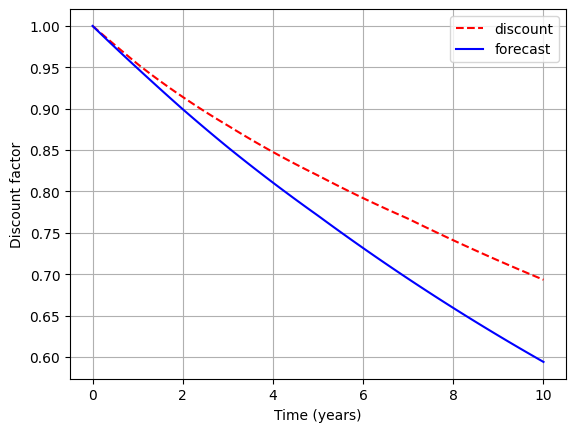

In [18]:
def main():
    # Convergence tolerance
    tol = 1.0e-15
    # Initial guess for the spine points
    r0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
    # Interpolation method
    method = linear_interpolation
    
    # Construct swaps that are used for building of the yield curve
    K = np.array([4.759/100, 4.515/100, 4.306/100, 4.025/100, 3.836/100, 3.714/100, 3.668/100, 3.509/100])
    mat = np.array([1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 30.0])
    
    #                   SingleCurve(Option type, Notional, K, t, Ti, Tm, n, P0T)
    swap1 = lambda P0T: SingleCurve(Derivative.OptionType.PAYER,1,K[0],0.0,0.0,mat[0],4*mat[0], P0T)
    swap2 = lambda P0T: SingleCurve(Derivative.OptionType.PAYER,1,K[1],0.0,0.0,mat[1],5*mat[1], P0T)
    swap3 = lambda P0T: SingleCurve(Derivative.OptionType.PAYER,1,K[2],0.0,0.0,mat[2],6*mat[2], P0T)
    swap4 = lambda P0T: SingleCurve(Derivative.OptionType.PAYER,1,K[3],0.0,0.0,mat[3],7*mat[3], P0T)
    swap5 = lambda P0T: SingleCurve(Derivative.OptionType.PAYER,1,K[4],0.0,0.0,mat[4],8*mat[4], P0T)
    swap6 = lambda P0T: SingleCurve(Derivative.OptionType.PAYER,1,K[5],0.0,0.0,mat[5],9*mat[5], P0T)
    swap7 = lambda P0T: SingleCurve(Derivative.OptionType.PAYER,1,K[6],0.0,0.0,mat[6],10*mat[6], P0T)
    swap8 = lambda P0T: SingleCurve(Derivative.OptionType.PAYER,1,K[7],0.0,0.0,mat[7],11*mat[7], P0T)
    instruments = [swap1,swap2,swap3,swap4,swap5,swap6,swap7,swap8]
    
    # determine optimal spine points
    ri = YieldCurve(instruments, mat, r0, method, tol)
    print(f'\n Spine points are {ri}\n')
    
    # Build a ZCB-curve/yield curve from the spine points
    P0T_Initial = lambda t: P0TModel(t,mat,r0,method)
    P0T = lambda t: P0TModel(t,mat,ri,method)
    
    # price back the swaps
    swapsModel = np.zeros(len(instruments))
    swapsInitial = np.zeros(len(instruments))
    for i in range(0,len(instruments)):
        swapsModel[i] = instruments[i](P0T)
        swapsInitial[i] = instruments[i](P0T_Initial)
    
    print(f'Prices for Par Swaps (initial) = {swapsInitial}\n')
    print(f'Prices for Par Swaps = {swapsModel}\n')
    
    # Multi Curve extension- simple sanity check
    P0TFrd = deepcopy(P0T)
    Ktest = 0.2
    swap1 = lambda P0T: SingleCurve(Derivative.OptionType.PAYER,1,Ktest,0.0,0.0,mat[0],4*mat[0],P0T)
    swap1MC = lambda P0T: MultiCurve(Derivative.OptionType.PAYER,1,Ktest,0.0,0.0,mat[0],4*mat[0],P0T,P0TFrd)
    print(f'Sanity check: swap1 = {swap1(P0T)}, swap2 = {swap1MC(P0T)}\n')
    
    # Forward curve settings
    r0Frwd = np.array([0.01, 0.01, 0.01, 0.01])
    KFrwd = np.array([5.3239/100.0, 5.3356/100.0, 5.3119/100.0, 5.2336/100.0])
    matFrwd = np.array([1.0, 2.0, 3.0, 5.0])
    
    # At this point we already know P(0,T) for the discount curve
    P0TDiscount = lambda t: P0TModel(t,mat,ri,method)
    swap1Frwd = lambda P0TFrwd: MultiCurve(Derivative.OptionType.PAYER,1,KFrwd[0],0.0,0.0,matFrwd[0],4*matFrwd[0],P0TDiscount,P0TFrwd)
    swap2Frwd = lambda P0TFrwd: MultiCurve(Derivative.OptionType.PAYER,1,KFrwd[1],0.0,0.0,matFrwd[1],5*matFrwd[1],P0TDiscount,P0TFrwd)
    swap3Frwd = lambda P0TFrwd: MultiCurve(Derivative.OptionType.PAYER,1,KFrwd[2],0.0,0.0,matFrwd[2],6*matFrwd[2],P0TDiscount,P0TFrwd)
    swap4Frwd = lambda P0TFrwd: MultiCurve(Derivative.OptionType.PAYER,1,KFrwd[3],0.0,0.0,matFrwd[3],7*matFrwd[3],P0TDiscount,P0TFrwd)
    
    instrumentsFrwd = [swap1Frwd,swap2Frwd,swap3Frwd,swap4Frwd]
    
    # determine optimal spine points for the forward curve
    riFrwd = YieldCurve(instrumentsFrwd, matFrwd, r0Frwd, method, tol)
    print(f'\n Frwd Spine points are {riFrwd}\n')
    
    # Build a ZCB-curve/yield curve from the spine points
    P0TFrwd_Initial = lambda t: P0TModel(t,matFrwd,r0Frwd,method)
    P0TFrwd = lambda t: P0TModel(t,matFrwd,riFrwd,method)
    # price back the swaps
    swapsModelFrwd = np.zeros(len(instrumentsFrwd))
    swapsInitialFrwd = np.zeros(len(instrumentsFrwd))
    
    for i in range(0,len(instrumentsFrwd)):
        swapsModelFrwd[i] = instrumentsFrwd[i](P0TFrwd)
        swapsInitialFrwd[i] = instrumentsFrwd[i](P0TFrwd_Initial)
    
    print('Prices for Pas Swaps (initial) = ',swapsInitialFrwd,'\n')
    print('Prices for Par Swaps = ',swapsModelFrwd,'\n')

    print(f'Price of the swap with 1 year to maturity at inception: {swap1Frwd(P0TFrwd)}')

    print(f'Price of the swap with 0.75 years to maturity at midway through the contract: {MultiCurve(Derivative.OptionType.PAYER,1,KFrwd[0],0.25,0.0,matFrwd[0],4*matFrwd[0],P0TDiscount,P0TFrwd)}')
    
    t = np.linspace(0,10,100)
    plt.figure()
    plt.plot(t,P0TDiscount(t),'--r')
    plt.plot(t,P0TFrwd(t),'-b')
    plt.legend(['discount','forecast'])
    plt.xlabel('Time (years)')
    plt.ylabel('Discount factor')
    plt.grid()
    plt.show()

main()